# Hyperparameter Tuning - Karşılaştırma

- Kısa bir karşılaştırma yaparak GridSearchCV, RandomizedSearchCV ve Optuna arasındaki farkları inceleyelim.

## Grid Search

- GridSearchCV, tüm parametre kombinasyonlarını deneyerek en iyi parametre setini bulmaya çalışan bir yöntemdir. Tüm olası kombinasyonları denediği için parametre sayısı arttıkça hesaplama süresi ciddi şekilde uzar.

## Random Search

- RandomizedSearchCV, parametrelerin rastgele seçilmiş kombinasyonlarını kullanarak en iyi parametre setini bulmaya çalışan bir yöntemdir. Parametre sayısı arttıkça, tüm kombinasyonları denemek yerine rastgele bir alt küme seçtiği için GridSearchCV'ye göre daha hızlı çalışır.

## Optuna

- Optuna, en iyi parametre setini bulmak için parametrelerin rastgele kombinasyonlarını deneyen bir yöntemdir. GridSearchCV'den ve RandomizedSearchCV'ye göre *genelde* (iterasyon sayısına bağlı olarak) daha hızlı çalışabilir, her zaman daha hızlı olacak diye bir durum söz konusu değildir. Ayrıca, parametreler arasındaki ilişkileri dikkate alarak daha iyi parametre kombinasyonları bulur. Bu, Bayesian Optimizasyon (varsayılanı bu şekilde fakat değiştirilebilir) yöntemi kullanılarak gerçekleştirilir.

In [9]:
import time

import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
import optuna

from sklearn.datasets import make_classification

sample_size = 5000
n_features = 24
n_classes = 5
X, y = make_classification(n_samples=sample_size, 
                           n_features=n_features,
                           n_classes=n_classes,
                           random_state=42,
                           n_informative=5)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline = Pipeline([
    ('svc', SVC())
])

# GridSearchCV ve RandomSearch için parametreler
hyperparameters = {
    'svc__C': [0.001, 0.1, 1, 10],
    'svc__kernel': ['linear', 'rbf', 'poly'],
    'svc__degree': [2, 3, 4],
    'svc__gamma': ['scale', 'auto']
}


# GridSearchCV
time_grid = time.time()
grid_search = GridSearchCV(pipeline, 
                           hyperparameters,
                           scoring='accuracy', 
                           cv=3,
                           n_jobs=-1,
                           verbose=3)

grid_search.fit(X_train, y_train)
print("Time taken: ", time.time() - time_grid)

best_grid_params = grid_search.best_params_
best_grid_pipeline = grid_search.best_estimator_

# 4 x 3 x 3 x 2 = 72 farklı parametre kombinasyonu denendi
# 3-fold cross validation yapıldı, totalde 72 x 3 = 216 fit
grid_search_accuracy = best_grid_pipeline.score(X_test, y_test)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Time taken:  25.38978338241577


In [10]:
# En iyi parametrelere dikkat edin, verdiğimiz parametrelerden bir kombinasyonu seçildi.
best_grid_params

{'svc__C': 1, 'svc__degree': 2, 'svc__gamma': 'auto', 'svc__kernel': 'rbf'}

### Sorun Nedir?

<br>

- En iyi `C` parametresinin 1 olarak seçildiğini gördük. Peki bundan daha iyi bir `C` değeri (örn: 0.2) olabilir miydi? GridSearchCV, bu soruyu cevaplamak için 0.1, 10 ve 100 gibi daha farklı değerlerle tekrar denemek zorunda kalırdı.

<br>

- GridSearch ve RandomSearch, parametreler arasındaki ilişkileri dikkate almaz (uninformative). Bu yüzden, `C` parametresinin 1 olduğu durumda, `gamma` parametresinin `scale` olması daha iyi bir sonuç verebilir. GridSearch ve RandomSearch, bu durumu göz ardı eder ve `C` parametresinin 1 olduğu durumda `gamma` parametresinin `auto` olması için deneme yapar.

<br>

- Her hiperparametre, modelin performansını aynı düzeyde etkilemez. Bayesian Optimizasyon ise bu ilişkileri göz önünde bulundurup, her parametrenin modeli ne kadar etkilediği ile ilgili çıkarım yaparak kombinasyonlar üretir. Yani belli set parametrelerinin verdiği performans değerine bakarak bir sonraki iterasyonda hangi parametrelerin değiştirilmesi gerektiğini belirlemeye çalışır.

In [11]:
# RandomizedSearchCV
time_rand = time.time()

random_search = RandomizedSearchCV(pipeline,
                                   hyperparameters,
                                   scoring='accuracy',
                                   cv=3,
                                   n_iter=30,
                                   n_jobs=-1,
                                   verbose=1,
                                   random_state=42)
random_search.fit(X_train, y_train)
print("Time taken: ", time.time() - time_rand)

best_random_params = random_search.best_params_
best_random_pipeline = random_search.best_estimator_

random_search_accuracy = best_random_pipeline.score(X_test, y_test)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Time taken:  10.421259641647339


In [12]:
best_random_params

{'svc__kernel': 'rbf', 'svc__gamma': 'auto', 'svc__degree': 3, 'svc__C': 1}

### Optuna ile Bayesian Optimizasyon

- Her sayısal parametre için bir aralık belirleriz. Optuna, bu aralıkta rastgele bir değer seçer ve bu değerlerle modeli eğitir. Eğitim sonucunda elde edilen performans değerine bağlı olarak ve parametre ilişkileri göz önünde bulundurularak, bir sonraki parametre değerlerinin seçilmesi için bir öneri (trial) yapılır.

In [13]:
def objective(trial):
    C = trial.suggest_float("svc__C", 0.001, 10, log=True)

    # Kategorik parametreler için sadece belirli değerler seçilebilir.
    kernel = trial.suggest_categorical("svc__kernel", ['linear', 'rbf', 'poly'])
    
    if kernel == 'poly':
        degree = trial.suggest_int("svc__degree", 2, 4)
    else:
        degree = 3
        
    if kernel in ['rbf', 'poly']:
        gamma = trial.suggest_categorical("svc__gamma", ['scale', 'auto'])
    else:
        gamma = 'scale'

    pipeline = Pipeline([
        ('svc', SVC(C=C, kernel=kernel, degree=degree, gamma=gamma))
    ])

    cv_scores = cross_val_score(pipeline, 
                                X_train,
                                y_train,
                                scoring='accuracy',
                                cv=3, 
                                n_jobs=-1)
    return np.mean(cv_scores)

# Optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

study = optuna.create_study(direction="maximize")

time_opt = time.time()

study.optimize(objective, n_trials=20)
print("Time taken: ", time.time() - time_opt)

best_optuna_params = study.best_trial.params

best_optuna_pipeline = Pipeline([
    ('svc', SVC(C=best_optuna_params['svc__C'], kernel=best_optuna_params['svc__kernel'], degree=best_optuna_params.get('svc__degree', 3), gamma=best_optuna_params.get('svc__gamma', "scale")))
])

best_optuna_pipeline.fit(X_train, y_train)
optuna_search_accuracy = best_optuna_pipeline.score(X_test, y_test)

Time taken:  8.100722551345825


In [17]:
# C değeri 1.0 değil, 1.62 olarak seçildi.
best_optuna_params

{'svc__C': 1.6225947346767138, 'svc__kernel': 'rbf', 'svc__gamma': 'auto'}

In [18]:
print("Grid search accuracy:", grid_search_accuracy)
print("Random search accuracy:", random_search_accuracy)
print("Optuna search accuracy:", optuna_search_accuracy)

Grid search accuracy: 0.695
Random search accuracy: 0.695
Optuna search accuracy: 0.703


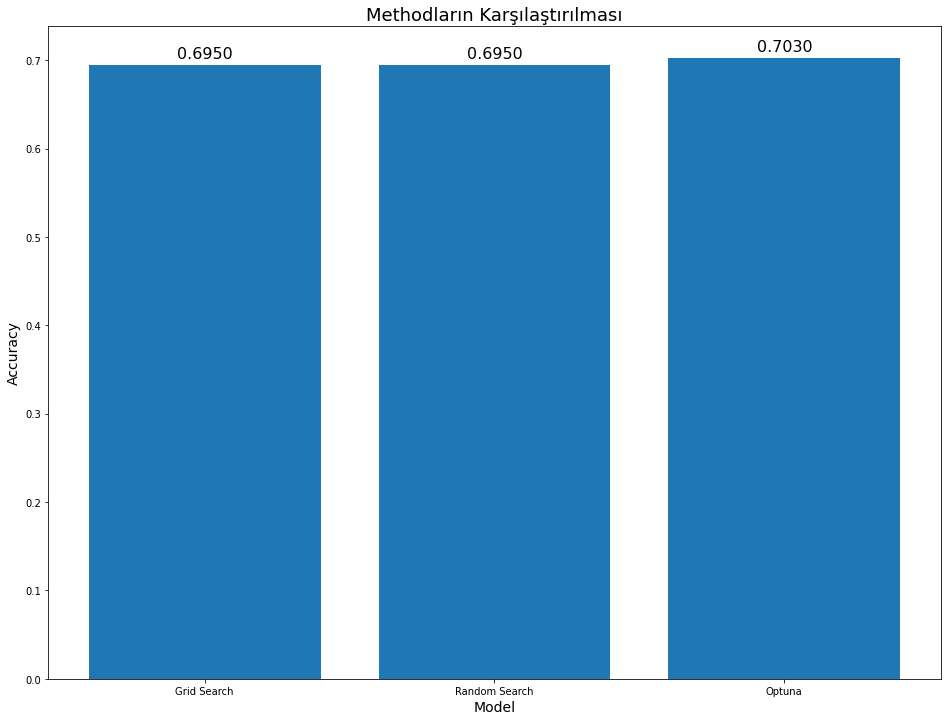

In [19]:
import matplotlib.pyplot as plt

methods = ['Grid Search', 'Random Search', 'Optuna']
accuracy_scores = [grid_search_accuracy, random_search_accuracy, optuna_search_accuracy]

fig, ax = plt.subplots(figsize = (16, 12))
bar_plot = ax.bar(methods, accuracy_scores)

for bar in bar_plot:
    height = bar.get_height()
    ax.annotate(
        f'{height:.4f}',
        xy=(bar.get_x() + bar.get_width() / 2, height),
        xytext=(0, 3),
        textcoords='offset points',
        ha='center',
        va='bottom', fontsize=16
    )

ax.set_title('Methodların Karşılaştırılması', fontsize=18)
ax.set_ylabel('Accuracy', fontsize=14)
ax.set_xlabel('Model', fontsize=14)

plt.show()